In [1]:
import tensorflow as tf
print(tf.keras.__version__)

2.4.0


# KERAS 2 CMSIS



In [2]:
import tensorflow as tf


mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1) ),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu',),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test, y_test)
model.summary()
model.save('mnist.keras')


Epoch 1/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1865 - accuracy: 0.9454
Epoch 2/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0622 - accuracy: 0.9809
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0470 - accuracy: 0.9858
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0361 - accuracy: 0.9888
Epoch 5/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0292 - accuracy: 0.9914
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0239 - accuracy: 0.9921
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0213 - accuracy: 0.9934
Epoch 8/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0177 - accuracy: 0.9945
Epoch 9/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0150 - accuracy: 0.9953
Epoch 10/10
313/313 [==============================] - 1s 3ms/st

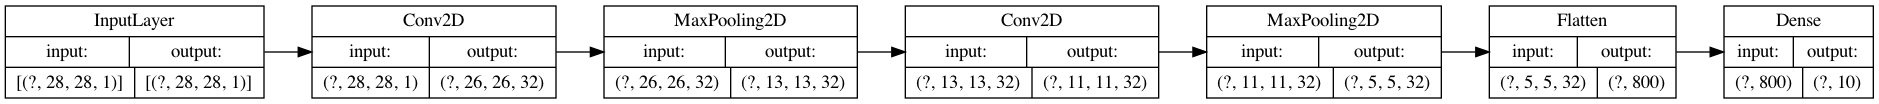

In [3]:
from keras.utils import plot_model
plot_model(model,
    show_layer_names=False, show_shapes=True, rankdir='LR', expand_nested=True, to_file='model.png')

# Generate code in c for cmsis

In [4]:
import keras as k
import numpy as np



In [5]:
#This is for fast quantization! Please check more advance methods
#To improve: you need to refine the activations of each layer!

fp = 'keras-weights.h'
print('Write weights and net parameters into:' + fp)
search_range=3

with open(fp, 'w') as f:
    wt_int_bits={}
    wt_dec_bits={}
    for layer in model.layers:

        weightsArray = layer.get_weights()

        write_name = layer.name.upper()
        
        idx =0
        bias = '_WT'
        for weight in weightsArray:
            print(weight.shape)
            #Find min and max of w's
            w_max = weight.max()
            w_min = weight.min() 
            
            int_bits = int(np.ceil(np.log2(max(abs(w_min),abs(w_max)))))
            frac_bits = 7 - int_bits#remaining bits are fractional bits (1-bit for sign)


            #floating point weights are scaled and rounded to [-128,127], which are used in 
            quant_weight = np.clip(np.round(weight*(2**frac_bits)), -128, 127)

    
            f.write('#define '+write_name+bias+' {')
            np.transpose(quant_weight).tofile(
                f, sep=", ", format="%d")
            f.write('}\n')
            if 'BIAS' in bias:
                f.write('#define '+write_name+'_BIAS_LSHIFT '+str(frac_bits)+'\n')
            else:
                f.write('#define '+write_name+'_OUT_RSHIFT '+str(frac_bits)+'\n')
            bias ='_BIAS'


Write weights and net parameters into:keras-weights.h
(3, 3, 1, 32)
(32,)
(3, 3, 32, 32)
(32,)
(800, 10)
(10,)


In [6]:
file_name = 'keras-parameters.h'
print('Generating parameter file: '+file_name)
f=open(file_name,'w')

for layer in model.layers:
    layer_no=model.layers.index(layer)
    if(layer_no>0):
        prev_layer=model.layers[layer_no-1]

    if layer.__class__.__name__=='Conv2D':
        LAYER=layer.name.upper()
        f.write("#define "+LAYER+"_IN_DIM "+str(layer.input_shape[1])+"\n")
        f.write("#define "+layer.name.upper()+"_IN_CH "+str(layer.input_shape[3])+"\n")
        f.write("#define "+layer.name.upper()+"_KER_DIM "+str(layer.kernel_size[1])+"\n")
        f.write("#define "+layer.name.upper()+"_PAD "+str(0)+"\n")
        f.write("#define "+layer.name.upper()+"_STRIDE "+str(layer.strides[1])+"\n")
        f.write("#define "+layer.name.upper()+"_OUT_CH "+str(layer.output_shape[3])+"\n")
        f.write("#define "+layer.name.upper()+"_OUT_DIM "+str(layer.output_shape[2])+"\n\n") 


    elif layer.__class__.__name__=='MaxPooling2D':
        f.write("#define "+layer.name.upper()+"_IN_DIM "+str(layer.input_shape[1])+"\n")
        f.write("#define "+layer.name.upper()+"_IN_CH "+str(layer.input_shape[3])+"\n")
        f.write("#define "+layer.name.upper()+"_KER_DIM "+str(layer.pool_size[1])+"\n")
        f.write("#define "+layer.name.upper()+"_PAD "+str(0)+"\n")
        f.write("#define "+layer.name.upper()+"_STRIDE "+str(layer.strides[1])+"\n")
        f.write("#define "+layer.name.upper()+"_OUT_DIM "+str(layer.output_shape[2])+"\n\n")
    elif  layer.__class__.__name__=='Dense':
        f.write("#define "+layer.name.upper()+"_DIM "+str(layer.input_shape[1])+"\n")
        f.write("#define "+layer.name.upper()+"_OUT "+str(layer.output_shape[1])+"\n")
        




f.close()

Generating parameter file: keras-parameters.h


In [7]:

file_name = 'keras-dnn.h'
print('Generating file: '+file_name)
f=open(file_name,'w')
f.write('\
#include "keras-weights.h"\n\
#include "keras-parameters.h"\n\
uint8_t run_nn(q7_t* input_data);\n\n\
')


for layer in model.layers:
    if layer.__class__.__name__=='Conv2D':
        f.write("static q7_t "+layer.name+"_wt["+layer.name.upper()+"_IN_CH*"+layer.name.upper()+"_KER_DIM*"+\
                layer.name.upper()+"_KER_DIM*"+layer.name.upper()+"_OUT_CH] = "+layer.name.upper()+"_WT;\n")
        f.write("static q7_t "+layer.name+"_bias["+layer.name.upper()+"_OUT_CH] = "+layer.name.upper()+"_BIAS;\n")
    elif layer.__class__.__name__=='Dense':
        f.write("static q7_t "+layer.name+"_wt["+layer.name.upper()+"_DIM *"+layer.name.upper()+"_OUT"+\
                "] = "+layer.name.upper()+"_WT;\n" )
        f.write("static q7_t "+layer.name+"_bias["+layer.name.upper()+"_OUT] = "+\
                layer.name.upper()+"_BIAS;\n\n")


conv_Highest_in = 1
conv_Highest_out = 1
dense_Highest = 1
pool_highest = 1

for layer in model.layers[0:len(model.layers)]:
    if "conv" in layer.name:        
        y = 1
        for x in layer.output_shape:
            if x is not None:
                y = y * x
        if y > conv_Highest_out:
            conv_Highest_out = y
            
        y = 1    
        for x in layer.input_shape:
            if x is not None:
                y = y * x
        if y > conv_Highest_in:
            conv_Highest_in = y    
            
    if "dense"  in layer.name:
        y = 1
        for x in layer.input_shape:
            if x is not None:
                y = y * x
        if y > dense_Highest:
            dense_Highest = y
            
    if "max_pooling" in layer.name:
        y = 1
        for x in layer.output_shape:
            if x is not None:
                y = y * x
        if y > pool_highest:
            pool_highest = y
            
f.write('static q7_t conv_buffer_out['+str(conv_Highest_out)+'];\n')
f.write('static q15_t conv_buffer_in['+str(conv_Highest_in)+'];\n')
f.write('static q7_t pool_out['+str(pool_highest)+'];\n')
f.write('static q15_t dense_buffer['+str(dense_Highest)+'];\n')
f.write('static q7_t y_out[10];\n\n')


lay = model.layers[0:len(model.layers)][0].name.upper()


f.write('uint8_t run_nn(q7_t* input_data) {\n')


#input convolution need to be RGB -> Cifar images have 3 dim
#Flag Input for the first layer
Input = 1

for layer in model.layers:
    LAYER = layer.name.upper()
    if layer.__class__.__name__=='Conv2D':
        if Input == 1:
            conv_func = 'arm_convolve_HWC_q7_RGB'
            f.write('  '+conv_func+'(input_data'+', '+LAYER+'_IN_DIM, '+LAYER+\
                            '_IN_CH, '+LAYER.lower()+'_wt, '+LAYER+'_OUT_CH, '+LAYER+'_KER_DIM, '+LAYER+'_PAD, '\
                            +LAYER+'_STRIDE, '+LAYER.lower()+'_bias, '+LAYER+'_BIAS_LSHIFT, '+LAYER+'_OUT_RSHIFT, '\
                            +'conv_buffer_out, '+LAYER+'_OUT_DIM, conv_buffer_in, NULL);\n')
            f.write('  arm_relu_q7('+'conv_buffer_out'+', '+LAYER+'_OUT_DIM*'+LAYER+'_OUT_DIM*'+\
                   LAYER+'_OUT_CH);\n')
            Input = 0
        else:
            conv_func = 'arm_convolve_HWC_q7_fast'
            f.write('  '+conv_func+'(pool_out'+', '+LAYER+'_IN_DIM, '+LAYER+\
                            '_IN_CH, '+LAYER.lower()+'_wt, '+LAYER+'_OUT_CH, '+LAYER+'_KER_DIM, '+LAYER+'_PAD, '\
                            +LAYER+'_STRIDE, '+LAYER.lower()+'_bias, '+LAYER+'_BIAS_LSHIFT, '+LAYER+'_OUT_RSHIFT, '\
                            +'conv_buffer_out, '+LAYER+'_OUT_DIM, conv_buffer_in, NULL);\n')
            f.write('  arm_relu_q7('+'pool_out'+', '+LAYER+'_OUT_DIM*'+LAYER+'_OUT_DIM*'+\
                   LAYER+'_OUT_CH);\n')
            
    elif layer.__class__.__name__=='MaxPooling2D':
        pool_func='arm_maxpool_q7_HWC'
        f.write('  '+pool_func+'('+'conv_buffer_out'+', '+LAYER+'_IN_DIM, '+LAYER+'_IN_CH, '+\
            LAYER+'_KER_DIM, '+LAYER+'_PAD, '+LAYER+'_STRIDE, '+LAYER+'_OUT_DIM, NULL, '+\
            ' pool_out'+');\n\n')
        
    elif  layer.__class__.__name__=='Dense':
        f.write('  arm_fully_connected_q7_opt(pool_out,'+LAYER.lower()+'_wt, '+LAYER+'_DIM, '+\
                LAYER+'_OUT, '+LAYER+'_BIAS_LSHIFT, '+\
                LAYER+'_OUT_RSHIFT, '+LAYER.lower()+'_bias, y_out, dense_buffer ) ;\n')
        f.write('  arm_softmax_q7(y_out, 10, y_out); \n')


f.write('  uint32_t index[1];\n  q7_t result[1];\n  uint32_t blockSize = sizeof(y_out);\n'+\
        '  arm_max_q7(y_out, blockSize, result, index);\n  return index[0];\n'

        )

f.write('}')
f.close()

Generating file: keras-dnn.h
